In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
%matplotlib inline

Create some sample data:

In [2]:
num_dxs = 50
num_findings = 20
#num_hidden = 100
avg_ddx_length = 5
avg_num_findings = 15
#ddx_max_length = 20 # this is the max length our graphical model can handle.
sample_size = 5

In [3]:

def logit(p):
    return np.log(p/(1.-p))
logit_p_offset = logit(float(avg_num_findings)/num_findings)

Generate a sparse matrix:

In [4]:
lam = 1.*avg_num_findings/num_findings
_W = np.random.poisson(lam = lam, size=[num_dxs,num_findings])*1.
_W*=np.random.gamma(shape = 1., size=[num_dxs, num_findings])
#_W

We generate random sparse cases, using a poisson distribution to randomly select the number of diagnoses and findings

In [5]:
def generate_random_case(num_dxs, num_findings, avg_ddx_length, w):
    """
    Generates a random case.

    Parameters:
        num_dxs (:class:`int`): the number of possible diagnoses
        num_findings (:class:`int`): the number of possible findings
        avg_ddx_length (:class:`int`): the average number of diagnoses in a differential
        W (:class:`np.array`): a weight matrix which correlates findings and diagnoses

    Returns:
        2-:class:`tuple` whose first component is a list of diagnoses, and whose second component is a list 
        of findings present.
    """

    def invlogit(x):
        return 1. / (1 + np.exp(-x))
    

    hidden_x = np.random.gamma(shape = 1.,size=num_dxs)\
                *np.random.poisson(lam = float(avg_ddx_length)/num_dxs, size=num_dxs)

    y = np.dot(hidden_x,w)
    findings_hot = np.random.binomial(n=1, p=invlogit(np.dot(hidden_x,w)+logit_p_offset))
    findings = [i for i in range(num_findings) if findings_hot[i] == 1]

    ddx_length = min(np.random.poisson(avg_ddx_length),num_dxs)

    from heapq import nlargest
    ddx = nlargest(ddx_length, range(num_dxs), key=lambda i: hidden_x[i])

    return (ddx, findings)

In [44]:
batch = (generate_random_case(num_dxs,
                              num_findings,
                              avg_ddx_length,
                              _W) for _ in xrange(sample_size))


In [45]:
np.sum(_W!=0,axis=1).mean()

11.16

In [46]:
# n = 0.
# for _,findings in batch:
#     n+=len(findings)
# n/sample_size

Ok, now we write code to process the data (so that we can feed it to our graphical model)

In [47]:


def _create_permutation_tensor(ddx):
    ddx_length = len(ddx)
    order = {big:o for o,big in enumerate(sorted(ddx))}
    reord_proj_tensor = np.zeros([ddx_length,ddx_length])
    for i in range(ddx_length):
        reord_proj_tensor[order[ddx[i]],i] +=1
    return reord_proj_tensor


def _prepare_data(ddx, findings, num_dxs, num_findings):
    
    reord_proj_tensor = _create_permutation_tensor(ddx)

    order = {big:o for o,big in enumerate(sorted(ddx))}
    indicator_array = np.ma.ones([len(ddx),len(ddx)])
    for i in range(0,len(ddx)):
        for j in range(i):
            indicator_array[i,order[ddx[j]]] = 0
        indicator_array[i,order[ddx[i]]] = np.ma.masked

    return (indicator_array, reord_proj_tensor, sorted(ddx), sorted(findings))


Code the probabilisitic model in pymc3:

In [48]:
from pymc3 import Model, Bernoulli, Normal, find_MAP
import theano.tensor as tt
#from pymc3.math import sigmoid

In [49]:
def _low_mem_graphical_model(dx_order_indicator_array_data, reord_proj_tensor, findings_data):
    """
    Builds the graphical model and ties the observable variables to the data. You can pass a batch of 
    :class:`int` `size` data; with :class:`int` `num_dxs` possible diagnoses, :class:`int` `num_findings`
    possible findings, and :class:`int` `ddx_max_length` maximum diagnoses in a given differential.

    Parameters:
        dx_order_indicator_array_data (:class:`np.array`): should be of shape 
            [`size`,`ddx_max_length`,`num_dxs`].
        diff_tensor_data (:class:`np.array`): should be of shape 
            [`size`,`num_dxs`,`ddx_max_length`,`num_dxs`].
        findings_data (:class:`np.array`): should be of shape 
            [`size`,`num_findings`]. 

    Returns:
        4-:tuple: containing (x, dx_order, W, findings), where
            x (:class:`Normal`): are hidden variables
            dx_order (:class:`Bernoulli`): indicate the order of diagnoses in the differential
            W (:class:`Normal`): is a matrix of parameters relating diagnoses to findings
            findings (:class:`Bernoulli`): indicate the presence of findings

    """
    # sigmoid function
    def invlogit(x):
        return 1. / (1 + tt.exp(-x))

    ddx_length, num_dxs = dx_order_indicator_array_data.shape
    num_findings = len(findings_data)

    x = Normal('x', mu = 0.1, sd = 10, shape = num_dxs)
    #V = Normal('V', mu=0, sd = 10, shape=[num_hidden,num_dxs],testval=np.random.randn(num_hidden,num_dxs)/num_dxs)
    #x = tt.tensordot(hidden_vars, V, axes=[1,0])
    if(ddx_length > 1):
        dx_order_s_1 = tt.tensordot(x, reord_proj_tensor,axes=[0,0])
        dx_order_s_1 = tt.reshape(dx_order_s_1,[ddx_length,1])
        dx_order_s_2 = tt.reshape(x,[1,num_dxs])
        dx_order_p = invlogit(tt.tile(dx_order_s_1,[1,num_dxs])-tt.tile(dx_order_s_2,[ddx_length,1]))
        dx_order = Bernoulli("dx_order", p=dx_order_p, observed=dx_order_indicator_array_data)
    else:
        dx_order = None
    dx_extra = Bernoulli("seen",p=invlogit(x),observed=1.)

    W = Normal('W', mu=0, sd=10., shape=[num_dxs, num_findings])

    findings_p = invlogit(tt.tensordot(x, W, axes=[0,0])+logit_p_offset)
    findings = Bernoulli("findings", findings_p, observed=np.ones([num_findings]))

    return (x, dx_order, W, findings)

In [50]:
def invert_permutation(perm):
    graph = enumerate(perm)
    graph_range_sorted = sorted(graph,key=lambda x:x[1])
    inverse_perm = zip(*graph_range_sorted)[0]
    return inverse_perm

def get_ordinal_permutation(list_of_distinct_ints):
    """
    Returns the ordinal permutation for a list of distinct ints; i.e. the integers in the list are replaced by their 
    relative ordinals. For example, given `[25,6,7,-3]`, this function would return `[3,1,2,0]`. Complexity is n*log(n),
    where n=len(list_of_distinct_ints).
    
    Parameters:
        perm (:class:`list`): A list of distinct integers (in an arbitrary order).

    Returns:
        :class:`list` A list consisting of exactly the integers 0-n, with the same relative order
            (where n=len(list_of_distinct_ints)).
    """
    order = {big:o for o,big in enumerate(sorted(list_of_distinct_ints))}
    ordinal_permutation = map(order.get,list_of_distinct_ints)
    return ordinal_permutation

In [51]:
local_param_cache = dict()
def cache_local_params(ddx,local_params_matrix):
    if local_params_matrix.shape in local_param_cache:
        return
    ddx_ordinal_perm = get_ordinal_permutation(ddx)
    local_param_cache[local_params_matrix.shape]=local_params_matrix[ddx_ordinal_perm,:]

def retrieve_cached_local_params(ddx,findings):
    shape = (len(ddx),len(findings))
    cached_local_params = local_param_cache.get(shape)
    if not (cached_local_params is None):
        ordinal_perm = get_ordinal_permutation(ddx)
        inverted_perm = invert_permutation(ordinal_perm)
        return cached_local_params[inverted_perm,:]
    return None
    

    

  Fit the model (aggregating individual MAP estimates - really this is the fist iteration of EM, but ok...):

In [52]:
W = dok_matrix((num_dxs,num_findings))
N = dok_matrix((num_dxs,num_findings))
cnt = 0
for ddx, findings in batch:
    if len(ddx)>0 and len(findings)>0:
        cnt+=1
        print("Iteration %d"%cnt)
        local_params = retrieve_cached_local_params(ddx,findings)
        preped_data = _prepare_data(ddx, findings, num_dxs, num_findings)
        dx_order_indicator_array, reord_proj_tensor, ddx_sorted, findings_sorted = preped_data
        if local_params is None: 
            with Model() as med_model:
                x, dx_order, W_loc, findings_rv = _low_mem_graphical_model(dx_order_indicator_array,
                                                                  reord_proj_tensor,
                                                                  findings_sorted)
            print("Model %d Loaded"%cnt)
            map_estimate = find_MAP(model=med_model)
            print("ddx: %r"%ddx)
            print("inferred: \n%r"%map_estimate['x'])
            order = {big:o for o,big in enumerate(sorted(ddx))}
            ddx_res = map(order.get,ddx)
            print(ddx_res)
            print("Map Estimate of W: \n%r"%map_estimate['W'][ddx_res,:])
            #if not (local_params is None):
            #    print(local_params-map_estimate['W'])
            cache_local_params(ddx,map_estimate['W'])
            local_params = map_estimate['W']
            print(map_estimate.keys())
        W[np.array(ddx_sorted)[:,np.newaxis],findings_sorted] += local_params
        N[np.array(ddx_sorted)[:,np.newaxis],findings_sorted] += 1

W[N != 0] /= N[N != 0]

Iteration 1
Model 1 Loaded
Optimization terminated successfully.
         Current function value: 279.481745
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
ddx: [21, 13, 0, 1, 2]
inferred: 
array([  5.56095031,   3.31019742,   1.14317997,   8.03212691,  11.00120884])
[4, 3, 0, 1, 2]
Map Estimate of W: 
array([[ 0.33635518,  0.33635518,  0.33635518,  0.33635518,  0.33635518,
         0.33635518,  0.33635518,  0.33635518,  0.33635518,  0.33635518,
         0.33635518,  0.33635518,  0.33635518,  0.33635518,  0.33635518,
         0.33635518],
       [ 0.24561437,  0.24561437,  0.24561437,  0.24561437,  0.24561437,
         0.24561437,  0.24561437,  0.24561437,  0.24561437,  0.24561437,
         0.24561437,  0.24561437,  0.24561437,  0.24561437,  0.24561437,
         0.24561437],
       [ 0.17007719,  0.17007719,  0.17007719,  0.17007719,  0.17007719,
         0.17007719,  0.17007719,  0.17007719,  0.17007719,  0.17007719,
         0.17007719,  0

Compare the estimate to the generating parameters...

In [15]:

def _create_order_projection_tensor(ddx_max_length, ddx_extended):
    num_dxs = len(ddx_extended)
    assert ddx_max_length <= num_dxs, "ddx_max_length: %d, num_dxs: %d"%(ddx_max_length,num_dxs)
    reord_proj_tensor = np.zeros([num_dxs,ddx_max_length])
    for i in range(ddx_max_length):
        reord_proj_tensor[ddx_extended[i],i] +=1
    return reord_proj_tensor


def _prepare_data(ddx,findings, num_dxs, num_findings, ddx_max_length):
    ddx_max_length = min(ddx_max_length,num_dxs) # ensure ddx_max_length is a lower bound.

    from itertools import ifilterfalse

    ddx_extended = ddx + list(ifilterfalse(ddx.__contains__, range(num_dxs)))

    findings_hot = np.zeros(num_findings, dtype=np.int)
    findings_hot[findings] = 1
    
    reord_proj_tensor = _create_order_projection_tensor(ddx_max_length,ddxs)

    indicator_array = np.ma.ones([ddx_max_length,num_dxs])
    for i in range(0,ddx_max_length):
        for j in range(i):
            indicator_array[i,ddx[j]] = 0
        indicator_array[i,ddx[i]] = np.ma.masked

    indicator_array[cur_ddx_len:,:] = np.ma.masked

    return (indicator_array, np.array(findings_hot_list), reord_proj_tensor)

In [16]:
def prediction_model(W,dx_order_indicator_array_data, reord_proj_tensor, findings_data):
    num_dxs,num_findings = W.shape
    
    x = Normal('x', mu = 0.1, sd = 10, shape = num_dxs)
    if(ddx_length > 1):
        dx_order_s_1 = tt.tensordot(x, reord_proj_tensor,axes=[0,0])
        dx_order_s_1 = tt.reshape(dx_order_s_1,[ddx_length,1])
        dx_order_s_2 = tt.reshape(x,[1,num_dxs])
        dx_order_p = invlogit(tt.tile(dx_order_s_1,[1,num_dxs])-tt.tile(dx_order_s_2,[ddx_length,1]))
        dx_order = Bernoulli("dx_order", p=dx_order_p, observed=dx_order_indicator_array_data)
    else:
        dx_order = None
    dx_extra = Bernoulli("seen",p=invlogit(x),observed=1.)

    W = Normal('W', mu=0, sd=10., shape=[num_dxs, num_findings])

    findings_p = invlogit(tt.tensordot(x, W, axes=[0,0])+logit_p_offset)
    findings = Bernoulli("findings", findings_p, observed=np.ones([num_findings]))

In [17]:


with Model() as med_model_predict:
    # sigmoid function
    def invlogit(x):
        return 1. / (1 + tt.exp(-x))

    ddx_length, num_dxs = dx_order_indicator_array_data.shape
    num_findings = len(findings_data)

    x = Normal('x', mu = 0.1, sd = 10, shape = num_dxs)
    #V = Normal('V', mu=0, sd = 10, shape=[num_hidden,num_dxs],testval=np.random.randn(num_hidden,num_dxs)/num_dxs)
    #x = tt.tensordot(hidden_vars, V, axes=[1,0])
    if(ddx_length > 1):
        dx_order_s_1 = tt.tensordot(x, reord_proj_tensor,axes=[0,0])
        dx_order_s_1 = tt.reshape(dx_order_s_1,[ddx_length,1])
        dx_order_s_2 = tt.reshape(x,[1,num_dxs])
        dx_order_p = invlogit(tt.tile(dx_order_s_1,[1,num_dxs])-tt.tile(dx_order_s_2,[ddx_length,1]))
        dx_order = Bernoulli("dx_order", p=dx_order_p, observed=dx_order_indicator_array_data)
    else:
        dx_order = None
    dx_extra = Bernoulli("seen",p=invlogit(x),observed=1.)

    W = Normal('W', mu=0, sd=10., shape=[num_dxs, num_findings])

    findings_p = invlogit(tt.tensordot(x, W, axes=[0,0])+logit_p_offset)
    findings = Bernoulli("findings", findings_p, observed=np.ones([num_findings]))

NameError: name 'dx_order_indicator_array_data' is not defined

In [ ]:
comparisons = 1./(1+np.exp(-map_estimate['hidden_vars'].dot(map_estimate['W'])))-findings_data
plt.hist(1./(1+np.exp(-map_estimate['hidden_vars'].dot(map_estimate['W'])))
         -findings_data)
plt.show()

In [ ]:
comparisons = 1./(1+np.exp(-np.einsum('ij,ijkl->ikl',np.dot(map_estimate['hidden_vars'],
                                                           map_estimate['V']),diff_tensor_data)))\
                    -dx_order_indicator_array_data
comparisons = comparisons.reshape([num_dxs,-1]).T

plt.hist(comparisons)
plt.show()

In [ ]:
from pymc3 import sample
#from scipy import optimize

with med_model:
    # draw 2000 posterior samples
    trace = sample(1000)

In [ ]:
from pymc3 import traceplot

In [ ]:
traceplot(trace)

In [ ]:
start = 10
from itertools import chain

In [ ]:

comparisons = np.vstack([1./(1+np.exp(-hid.dot(w)))
         -findings_data for hid,w in zip(trace['hidden_vars'][-start:],trace['W'][-start:])])
               
#comparison = chain.from_iterable(comparisons)

plt.hist(comparisons)
plt.show()

In [ ]:
comparisons = np.ma.vstack([1./(1+np.exp(-np.einsum('ij,ijkl->ikl',np.dot(hid,v),diff_tensor_data)))
                    -dx_order_indicator_array_data 
               for hid,v in zip(trace['hidden_vars'][-start:],trace['V'][-start:])]).T
comparisons = comparisons.reshape([num_dxs,-1]).T
#comparisons = comparisons[comparisons.mask==False]


plt.hist(comparisons)
plt.show()

/Users/libland/miniconda2/envs/pymc3_test/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6087: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 1 x 1000)
  '(shape is %d x %d)' % inp.shape[::-1])


KeyboardInterrupt: 

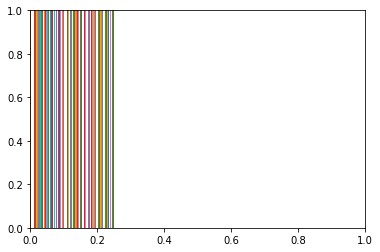

In [18]:
plt.hist((W-_W).reshape([-1]))

In [ ]:
plt.hist((0-_W).reshape([-1]))

In [44]:
W

array([[ 0.30169557,  0.30814383,  0.2971775 ,  0.39282128,  0.35273783,
         0.36914026,  0.36439468,  0.33568688,  0.32581004,  0.41140806],
       [ 0.41828603,  0.38017522,  0.33647847,  0.29991361,  0.3864158 ,
         0.37781113,  0.37381359,  0.24548688,  0.35247719,  0.2986424 ],
       [ 0.33245585,  0.29434949,  0.45746341,  0.37740589,  0.36203718,
         0.37904643,  0.39881669,  0.38128621,  0.41995919,  0.30518777],
       [ 0.38046228,  0.40998092,  0.32471794,  0.4036867 ,  0.37078999,
         0.36995403,  0.39157169,  0.42570066,  0.33849418,  0.32115724],
       [ 0.34801488,  0.4002106 ,  0.36276841,  0.38406521,  0.35900055,
         0.37200588,  0.22883662,  0.39451811,  0.32019402,  0.40508064]])

In [45]:
_W

array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.00981045, -0.        , -0.63962823, -0.        ,  1.7958131 ],
       [ 0.67279629,  0.3215445 ,  0.        , -0.59369557,  0.        ,
         0.        , -0.20515441, -1.8712558 , -0.        , -0.        ],
       [-0.        , -0.46299313,  2.75677448,  0.03720852, -0.        ,
         0.        , -0.        , -0.        ,  1.01455315, -0.        ],
       [ 0.48065189,  0.79646302, -0.        , -0.        , -0.        ,
         0.        , -0.        ,  0.44392842, -0.        , -0.        ],
       [ 0.        ,  0.76790261,  0.73802119, -0.        ,  0.        ,
        -0.        , -1.19113878,  0.        ,  0.        ,  1.72832754]])

In [49]:
map_estimate['W']

array([[ 0.37421992,  0.37421992,  0.37421992,  0.37421992,  0.37421992],
       [ 0.63261911,  0.63261911,  0.63261911,  0.63261911,  0.63261911],
       [ 0.14934929,  0.14934929,  0.14934929,  0.14934929,  0.14934929]])

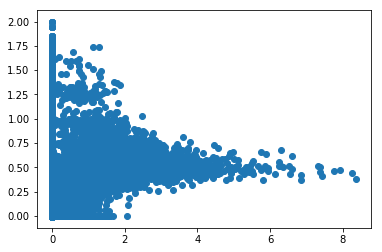

In [17]:

plt.scatter(x=_W,y=W)

In [61]:
map_estimate['W']

array([[ 0.14934929,  0.14934929,  0.14934929,  0.14934929,  0.14934929],
       [ 0.63261911,  0.63261911,  0.63261911,  0.63261911,  0.63261911],
       [ 0.37421992,  0.37421992,  0.37421992,  0.37421992,  0.37421992]])

In [68]:
ddx = [1,2]
for i in range(15):
    findings = range(i)
    if len(ddx)>0 and len(findings)>0:
        preped_data = _prepare_data(ddx, findings, num_dxs, num_findings)
        dx_order_indicator_array, reord_proj_tensor, ddx_sorted, findings_sorted = preped_data
        with Model() as med_model:
            x, dx_order, W_loc, findings_rv = _low_mem_graphical_model(dx_order_indicator_array,
                                                              reord_proj_tensor,
                                                              findings_sorted)
        print("Model %d Loaded"%np.max(N))
        map_estimate = find_MAP(model=med_model)
        print("ddx: %r"%ddx)
        print("inferred: \n%r"%map_estimate['x'])
        print("Map Estimat of W: \n%r"%map_estimate['W'])
        W[np.array(ddx_sorted)[:,np.newaxis],findings_sorted] += map_estimate['W']
        N[np.array(ddx_sorted)[:,np.newaxis],findings_sorted] += 1

Model 40 Loaded
Optimization terminated successfully.
         Current function value: 14.622457
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
ddx: [1, 2]
inferred: 
array([ 6.02203819,  2.46359117])
Map Estimat of W: 
array([[ 0.921826  ],
       [ 0.37718303]])
Model 40 Loaded
Optimization terminated successfully.
         Current function value: 21.071966
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
ddx: [1, 2]
inferred: 
array([ 6.05762738,  2.4818141 ])
Map Estimat of W: 
array([[ 0.91752672,  0.91752672],
       [ 0.37594689,  0.37594689]])
Model 40 Loaded
Optimization terminated successfully.
         Current function value: 27.521415
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
ddx: [1, 2]
inferred: 
array([ 6.09259755,  2.49971178])
Map Estimat of W: 
array([[ 0.91334417,  0.91334417,  0.91334417],
       [ 0.37475556,  0.37475556,  0.3747

IndexError: index 10 is out of bounds for axis 1 with size 10

In [77]:
type(W.shape)

tuple

In [16]:
map_estimate.keys()

['x', 'dx_order_missing', 'W']

In [53]:
print(W)

  (16, 9)	0.0653841752657
  (19, 4)	0.111394094767
  (22, 19)	0.416293907127
  (44, 4)	0.282596700658
  (47, 9)	0.189915685225
  (21, 6)	0.336355184172
  (45, 9)	0.214740945545
  (36, 8)	0.160373278177
  (37, 13)	0.11176528701
  (0, 17)	0.0453279354406
  (24, 14)	0.160328628193
  (14, 1)	0.148612978048
  (25, 15)	0.21470226536
  (39, 11)	0.111442331397
  (26, 12)	0.169399431815
  (3, 2)	0.0653463827733
  (16, 0)	0.0653841752657
  (19, 13)	0.111394094767
  (44, 3)	0.282596700658
  (21, 15)	0.336355184172
  (45, 2)	0.214740945545
  (22, 12)	0.416293907127
  (14, 8)	0.148612978048
  (25, 16)	0.21470226536
  (39, 0)	0.111442331397
  :	:
  (21, 10)	0.336355184172
  (22, 1)	0.416293907127
  (14, 13)	0.148612978048
  (13, 8)	0.263216331894
  (26, 16)	0.169399431815
  (0, 3)	0.0702777858368
  (24, 0)	0.160328628193
  (3, 14)	0.0653463827733
  (1, 2)	0.0445017347403
  (2, 9)	0.0231953724894
  (40, 9)	0.240605010041
  (16, 18)	0.0653841752657
  (21, 19)	0.336355184172
  (44, 13)	0.282596700658
 

In [72]:
W1 = W.toarray()

In [74]:
W[N != 0] /= N[N!=0]

In [75]:
W-W1

matrix([[-0.01124445, -0.01194943, -0.00849899, -0.01124445, -0.01194943,
         -0.01124445, -0.01124445, -0.01124445, -0.01124445, -0.01124445,
         -0.01553402, -0.01124445, -0.01124445, -0.01124445, -0.01124445,
         -0.01124445, -0.01124445, -0.00849899, -0.01124445, -0.01124445],
        [-0.01821956,  0.        ,  0.        , -0.01821956,  0.        ,
         -0.01821956, -0.01821956, -0.01821956, -0.01821956, -0.01821956,
         -0.01821956, -0.01821956, -0.01821956, -0.01821956, -0.01821956,
         -0.01821956, -0.01821956,  0.        , -0.01821956, -0.01821956],
        [-0.00579884,  0.        ,  0.        , -0.00579884,  0.        ,
         -0.00579884, -0.00579884, -0.00579884, -0.00579884, -0.00579884,
         -0.00579884, -0.00579884, -0.00579884, -0.00579884, -0.00579884,
         -0.00579884, -0.00579884,  0.        , -0.00579884, -0.00579884],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , 

In [63]:
print(W1.toarray()-W.toarray())

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [32]:
N1.toarray()

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,
         2.,  2.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

In [76]:
import scipy
scipy.__version__

'0.19.0'